# Project -2 : Build NLP Classifier to detect whether a sentence is sarcastic or not, using Bidirectional LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Refrences 
1) https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

# Read and explore the dat

In [3]:
cd '/content/drive/MyDrive/LablFiles/SequenceNLP_Internal/Project_2/'

/content/drive/MyDrive/LablFiles/SequenceNLP_Internal/Project_2


In [4]:
import json

In [5]:
data = []
for line in open('Sarcasm_Headlines_Dataset.json', 'r'):
    data.append(json.loads(line))

In [6]:
df = pd.DataFrame(data)

In [7]:
df.head(3)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...


In [8]:
#delete article_link field as it is not required
df.drop(columns=['article_link'], inplace=True)

In [9]:
df.head(2)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...


# Data Analyses

In [10]:
print("Number of records", df.shape[0])
print("No of labels", np.unique(df['is_sarcastic']))

Number of records 28619
No of labels [0 1]


Lets check number of words and no of characters each records to understand data set

In [11]:
df['Noofwords'] = df['headline'].apply(lambda x : len(x.split(' ')) )

In [12]:
df['Noofchars'] = df['headline'].apply(lambda x : len(x))

In [13]:
df.sample(4)

,is_sarcastic,headline,Noofwords,Noofchars
9892,1,man keeping running total of how many people i...,15,75
9928,0,anne hathaway to moms: 'there is no shame in g...,13,77
24059,1,new study finds running for 20 minutes each da...,16,83
12771,0,pissed off from a lack of sleep? you might be ...,11,55


In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_sarcastic,28619.0,0.476397,0.499451,0.0,0.0,0.0,1.0,1.0
Noofwords,28619.0,10.051854,3.390939,2.0,8.0,10.0,12.0,151.0
Noofchars,28619.0,62.308571,20.726483,7.0,49.0,62.0,75.0,926.0


In [15]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [16]:
df['is_sarcastic'].value_counts()/len(df['is_sarcastic'])

0    0.523603
1    0.476397
Name: is_sarcastic, dtype: float64

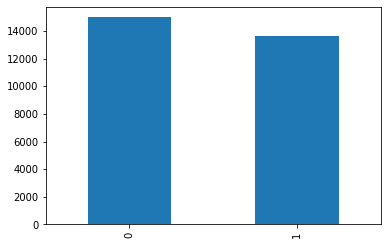

In [17]:
df['is_sarcastic'].value_counts().plot(kind='bar')

In [18]:
df.isna().sum()

is_sarcastic    0
headline        0
Noofwords       0
Noofchars       0
dtype: int64

Observations on data....
1) The data is reasonably balanced in terms of number of target label i.e. sarcastic (47% of records) and non sarcastic records(52% of records)
2) No of words - 75% records have total word count <=12
3) No null records found

Lets do tokenisation and see word count, frequency of words etc

In [19]:
import tensorflow as tf

In [20]:
token = tf.keras.preprocessing.text.Tokenizer()

In [21]:
token.fit_on_texts(df['headline'])

In [22]:
print("No of words in the dataset -", len(token.word_index))

No of words in the dataset - 30884


Lets see word frequency....

In [23]:
dfwordfre = pd.DataFrame.from_dict(token.word_counts,orient="index",columns=['WordCount'])

In [24]:
dfwordfre.sort_values('WordCount',ascending=False)

,WordCount
to,9096
of,6292
the,5313
in,4586
for,3639
...,...
estrada,1
tapping,1
quaaludes,1
quaalude,1


In [25]:
print("No of words having frequency <=1", len(dfwordfre[dfwordfre['WordCount'] <=1]))
print("No of words having frequency <=2", len(dfwordfre[dfwordfre['WordCount'] <=2]))
print("No of words having frequency <=3", len(dfwordfre[dfwordfre['WordCount'] <=3]))
print("No of words having frequency <=4", len(dfwordfre[dfwordfre['WordCount'] <=4]))
print("No of words having frequency <=5", len(dfwordfre[dfwordfre['WordCount'] <=5]))
print("No of words having frequency <=6", len(dfwordfre[dfwordfre['WordCount'] <=6]))
print("No of words having frequency <=7", len(dfwordfre[dfwordfre['WordCount'] <=7]))
print("No of words having frequency <=8", len(dfwordfre[dfwordfre['WordCount'] <=8]))

No of words having frequency <=1 14882
No of words having frequency <=2 19459
No of words having frequency <=3 21865
No of words having frequency <=4 23412
No of words having frequency <=5 24468
No of words having frequency <=6 25221
No of words having frequency <=7 25823
No of words having frequency <=8 26306


# Build Model

In [26]:
# Keep only required fields in the dataset
dffinal = df[['is_sarcastic','headline']]

In [27]:
dffinal.dtypes

is_sarcastic     int64
headline        object
dtype: object

In [28]:
dffinal.shape

(28619, 2)

In [29]:
 # Lets condier top 10,000 frequently words from the data for model building
max_features = 10000             
# In the above section we have seen 75% records have word count <=12...So I am considering max word count 12
maxlen = 40            
embedding_size = 50

In [30]:
X= dffinal['headline']
Y = dffinal['is_sarcastic']

In [31]:
token = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
token.fit_on_texts(X)

In [32]:
X = token.texts_to_sequences(X)

Lets do padding

In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
Xpadded = tf.keras.preprocessing.sequence.pad_sequences(X,maxlen=maxlen,padding='pre',truncating='post')

The data is related to news website...thus the words used are very common/generic for experessing sarcastic and non sarcastic sentiment

So lets go with pre built embedding models for word embedding...such as glove as it is built with vast public data source

In [35]:
# I am using file stored in my google drive
embeddingFile = '/content/drive/MyDrive/LablFiles/SequenceNLP_Internal/glove.6B.50d.txt'

In [36]:
embeddingdic = {}

for f in open(embeddingFile) :
  word = f.split(" ")[0]
  embededval = f.split(" ")[1:]
  embededval = np.asarray(embededval,dtype='float32')
  embeddingdic[word] =embededval

In [37]:
len(embeddingdic)

400000

Lets check words randomly from the data set and check if they exists in embedding matrix

In [44]:
embeddingdic['lesbian']

array([-0.064624,  0.43162 , -1.5065  , -0.086348,  0.76953 ,  1.5277  ,
       -0.6872  , -0.68823 ,  0.23599 , -0.040826, -0.12382 , -0.64217 ,
        0.5358  ,  0.79315 ,  0.58661 , -1.0421  , -0.093324, -0.21653 ,
        0.18978 ,  0.11308 , -0.12066 ,  1.0616  , -0.30056 ,  1.4916  ,
       -0.35642 , -0.68397 , -0.34435 , -0.72821 , -0.56614 , -0.59494 ,
        1.0294  ,  0.7847  , -0.51818 , -1.0029  , -1.712   , -0.8627  ,
       -0.59624 , -1.3236  , -0.48638 , -0.49299 , -0.014158, -0.38806 ,
        0.34215 ,  0.62086 ,  0.24643 , -0.73079 , -0.56063 , -0.77281 ,
       -0.15972 ,  0.79533 ], dtype=float32)

In [45]:
embeddingdic['shoots']

array([ 1.0445e-02,  1.1589e-01,  8.6453e-01, -3.1331e-01,  9.0984e-01,
        9.6867e-01, -1.9005e-01, -1.0643e-01,  3.1357e-02, -1.3212e-01,
       -5.0441e-01, -3.7681e-01, -1.4322e-01,  6.5542e-01,  9.3749e-02,
       -1.6938e-01,  1.5793e-01,  5.3349e-01, -6.8024e-01, -1.4736e-01,
       -1.1440e-01,  5.5359e-01,  6.0991e-01,  2.5012e-01,  7.4156e-01,
       -5.0437e-01,  6.7438e-01,  3.7927e-01,  6.4163e-01, -5.2942e-01,
        9.6961e-01, -2.1856e-01,  8.9965e-02,  2.3869e-01,  1.2944e-01,
        6.7146e-01, -3.2667e-01,  2.4360e-01,  1.7480e-01, -6.4635e-01,
        1.5126e-01,  1.8167e-01, -1.1395e-03, -5.1748e-01,  1.4063e+00,
       -5.2612e-01,  1.0988e+00, -8.6113e-01,  3.8733e-01,  2.9969e-01],
      dtype=float32)

In [46]:
embeddingdic['attack']

array([ 1.4703   , -0.9337   ,  0.51369  , -0.19082  ,  0.50227  ,
        0.13241  ,  0.12726  ,  0.63662  , -0.13905  , -0.32585  ,
       -0.46345  , -0.91213  , -0.88935  , -0.023272 , -0.48632  ,
       -0.22256  ,  0.077578 , -0.21413  , -1.7487   ,  0.81504  ,
       -0.25526  ,  0.61326  ,  0.097635 ,  0.0040341,  0.02032  ,
       -2.2944   , -0.11007  , -0.12472  ,  0.85396  ,  0.13095  ,
        2.7334   ,  0.020801 , -0.8306   , -0.52641  ,  0.35823  ,
        0.5293   ,  0.5239   , -0.97954  , -0.89408  ,  0.56206  ,
       -0.094276 ,  0.38047  ,  0.064524 , -0.79603  ,  1.4988   ,
        0.10214  , -0.41158  ,  0.47262  ,  0.65586  , -0.10645  ],
      dtype=float32)

In [47]:
embeddingdic['crackdown']

array([ 0.0032668, -0.97774  ,  0.34239  , -0.33168  , -1.0193   ,
       -0.63638  ,  0.8741   , -0.30754  ,  0.16918  ,  1.0034   ,
       -0.81639  , -1.6908   , -0.71362  , -0.091598 ,  0.77081  ,
       -0.63527  , -0.39448  , -0.61519  ,  0.34299  ,  0.59082  ,
        0.50487  , -0.26771  , -0.43262  , -0.13201  , -1.0886   ,
       -1.7671   ,  0.30204  , -0.38226  ,  0.061394 ,  0.66425  ,
        2.0586   ,  0.19427  , -1.0699   , -0.62804  , -1.0224   ,
        0.22305  , -0.24518  , -1.2119   , -1.3688   ,  0.37789  ,
       -1.1178   ,  0.70941  , -0.097047 , -0.46983  ,  1.0567   ,
       -0.69863  , -0.28335  ,  0.25504  , -0.1096   , -1.1878   ],
      dtype=float32)

Lets create weight matrix for words in the data set 

In [38]:
embedding_matrix = np.zeros((max_features + 1, embedding_size))

In [39]:
for word, i in sorted(token.word_index.items(),key=lambda x:x[1]):
    if i > max_features :
      break    
    embedding_vector = embeddingdic.get(word)
    if embedding_vector is not None :
      embedding_matrix[i]  =   embedding_vector

In [40]:
embedding_matrix.shape

(10001, 50)

In [41]:
embedding_matrix[1]

array([ 0.68046999, -0.039263  ,  0.30186   , -0.17792   ,  0.42962   ,
        0.032246  , -0.41376001,  0.13228001, -0.29846999, -0.085253  ,
        0.17117999,  0.22419   , -0.10046   , -0.43652999,  0.33418   ,
        0.67846   ,  0.057204  , -0.34448001, -0.42785001, -0.43274999,
        0.55962998,  0.10032   ,  0.18677001, -0.26853999,  0.037334  ,
       -2.09319997,  0.22171   , -0.39868   ,  0.20912001, -0.55725002,
        3.88260007,  0.47466001, -0.95657998, -0.37788001,  0.20869   ,
       -0.32752001,  0.12751   ,  0.088359  ,  0.16350999, -0.21634001,
       -0.094375  ,  0.018324  ,  0.21048   , -0.03088   , -0.19722   ,
        0.082279  , -0.09434   , -0.073297  , -0.064699  , -0.26043999])

Split the data into train, test sets

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
x_train, x_test, y_train, y_test = train_test_split(Xpadded,Y,test_size=0.3,random_state=34,stratify=Y)

In [44]:
x_train.shape

(20033, 40)

In [45]:
x_test.shape

(8586, 40)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Flatten, BatchNormalization, Bidirectional,SpatialDropout1D

# Model-11 : Using glove embedding and LSTM

In [47]:
tf.keras.backend.clear_session()
model = Sequential()

In [48]:
maxlen = 40
model.add(Embedding(max_features+1, embedding_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(LSTM(128,return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.15))
model.add(Dense(64,activation='tanh'))
model.add(Dense(1,activation='sigmoid'))

In [49]:
model.compile(optimizer='adam',metrics=['accuracy'], loss='categorical_crossentropy')

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            500050    
_________________________________________________________________
lstm (LSTM)                  (None, 40, 128)           91648     
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                327744    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 919,507
Trainable params: 419,457
Non-trainable params: 500,050
____________________________________________

In [51]:
batchsize = 512
epochs = 4

In [52]:
history = model.fit(x_train, y_train, batch_size=batchsize, epochs= epochs,validation_data=(x_test, y_test))

Epoch 1/4
40/40 [==============================] - 19s 431ms/step - loss: 0.0000e+00 - accuracy: 0.5217 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 2/4
40/40 [==============================] - 17s 428ms/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 3/4
40/40 [==============================] - 17s 430ms/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 4/4
40/40 [==============================] - 17s 428ms/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236


# Model-12 : Using glove embedding and Birectional

In [53]:
tf.keras.backend.clear_session()
model = Sequential()
maxlen = 40
model.add(Embedding(max_features+1, embedding_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(SpatialDropout1D(0.5))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150,dropout=0.2, recurrent_dropout=0.2)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [54]:
model.compile(optimizer='adam',metrics=['accuracy'], loss='categorical_crossentropy')

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            500050    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               241200    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 741,551
Trainable params: 241,501
Non-trainable params: 500,050
_________________________________________________________________


In [56]:
batchsize = 256
epochs = 4

In [57]:
history = model.fit(x_train, y_train, batch_size=batchsize, epochs= epochs,validation_data=(x_test, y_test))

Epoch 1/4
79/79 [==============================] - 73s 860ms/step - loss: 0.0000e+00 - accuracy: 0.5227 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 2/4
79/79 [==============================] - 69s 878ms/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 3/4
79/79 [==============================] - 67s 851ms/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 4/4
79/79 [==============================] - 67s 846ms/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236


In [58]:
model.save('/content/drive/MyDrive/LablFiles/SequenceNLP_Internal/Project2_model22.h5')

In [59]:
result = model.evaluate(x_test,y_test)

269/269 [==============================] - 9s 32ms/step - loss: 0.0000e+00 - accuracy: 0.5236


In [60]:
print("Test Loss and Accuracy",result)

Test Loss and Accuracy [0.0, 0.5236431360244751]


In [61]:
print("Average accuracy",np.mean(history.history["accuracy"]))

Average accuracy 0.5233739465475082


Model23- Lets try without glove embedding

In [63]:
tf.keras.backend.clear_session()
model23 = Sequential()
maxlen = 40
#model.add(Embedding(max_features+1, embedding_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model23.add(Embedding(max_features+1, 128,input_length =maxlen))
model23.add(SpatialDropout1D(0.4))
model23.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(196,dropout=0.2, recurrent_dropout=0.2)))
model23.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [64]:
model23.compile(optimizer='adam',metrics=['accuracy'], loss='categorical_crossentropy')

In [65]:
batchsize = 128
history = model23.fit(x_train, y_train, batch_size=batchsize, epochs= epochs,validation_data=(x_test, y_test))

Epoch 1/4
157/157 [==============================] - 181s 1s/step - loss: 0.0000e+00 - accuracy: 0.5235 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 2/4
157/157 [==============================] - 173s 1s/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 3/4
157/157 [==============================] - 172s 1s/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236
Epoch 4/4
157/157 [==============================] - 172s 1s/step - loss: 0.0000e+00 - accuracy: 0.5236 - val_loss: 0.0000e+00 - val_accuracy: 0.5236


In [66]:
model23.save('/content/drive/MyDrive/LablFiles/SequenceNLP_Internal/Project2_model23.h5')

In [67]:
result23 = model23.evaluate(x_test,y_test)

269/269 [==============================] - 16s 58ms/step - loss: 0.0000e+00 - accuracy: 0.5236


In [68]:
print("Test Loss and Accuracy",result23)

Test Loss and Accuracy [0.0, 0.5236431360244751]


In [69]:
print("Average accuracy",np.mean(history.history["accuracy"]))

Average accuracy 0.5235736072063446


# Conclusion/Observation

In the above section different models were built - LSTM, Bidirectional - with glove and without glove embedding.
All models are giving same accuracy

# Model-21 : Using gensim library, Word2Vec embedding & Bidirectional LSTM

In [70]:
import gensim
import gensim.downloader as api

Load already trained gensim embedding

In [71]:
word2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Store doanloaded file in some folder in google drive so that next time 
we can load model directly from file instead of downloading

In [72]:
word2vec

In [73]:
embedding_size = word2vec.wv.syn0.shape[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [74]:
embedding_size

300

In [75]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [76]:
embedding_matrix = np.zeros((max_features + 1, embedding_size))

In [77]:
for word, i in sorted(token.word_index.items(),key=lambda x:x[1]):
    if i > max_features:
        break
    #if word in word2vec.key_to_index :
    if word in word2vec.wv.vocab :
        embedding_vector = word2vec.wv[word]
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [78]:
embedding_matrix.shape

(10001, 300)

In [79]:
tf.keras.backend.clear_session()
mode21 = Sequential()
mode21.add(Embedding(max_features+1,embedding_size,weights=[embedding_matrix], input_length=maxlen,trainable=False))
mode21.add(LSTM(128,return_sequences=True))
mode21.add(Dropout(0.15))
mode21.add(Dense(64,activation='tanh'))
mode21.add(Dense(1,activation='sigmoid'))

In [80]:
mode21.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           3000300   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 128)           219648    
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 40, 64)            8256      
_________________________________________________________________
dense_1 (Dense)              (None, 40, 1)             65        
Total params: 3,228,269
Trainable params: 227,969
Non-trainable params: 3,000,300
_________________________________________________________________


In [81]:
mode21.compile(optimizer='adam',metrics=['accuracy'], loss='binary_crossentropy')

In [82]:
batchsize = 128
epochs = 5

In [83]:
history21 = mode21.fit(x_train, y_train, batch_size=batchsize, epochs= epochs,validation_data=(x_test, y_test))

Epoch 1/5
157/157 [==============================] - 35s 211ms/step - loss: 0.6585 - accuracy: 0.5667 - val_loss: 0.6479 - val_accuracy: 0.5797
Epoch 2/5
157/157 [==============================] - 33s 208ms/step - loss: 0.6408 - accuracy: 0.5813 - val_loss: 0.6399 - val_accuracy: 0.5842
Epoch 3/5
157/157 [==============================] - 32s 207ms/step - loss: 0.6323 - accuracy: 0.5856 - val_loss: 0.6342 - val_accuracy: 0.5711
Epoch 4/5
157/157 [==============================] - 35s 220ms/step - loss: 0.6266 - accuracy: 0.5874 - val_loss: 0.6309 - val_accuracy: 0.5894
Epoch 5/5
157/157 [==============================] - 33s 209ms/step - loss: 0.6220 - accuracy: 0.5916 - val_loss: 0.6323 - val_accuracy: 0.5899


In [84]:
# save the model to disk
mode21.save('/content/drive/MyDrive/LablFiles/SequenceNLP_Internal/Project1_model21.h5')

#from keras.models import load_model
#loaded_model = load_model('/content/drive/MyDrive/LablFiles/SequenceNLP_Internal/Project1_model21.h5')

In [86]:
result21 = mode21.evaluate(x_test,y_test)

print("Test Loss and Accuracy",result21)

print("Average accuracy",np.mean(history21.history["accuracy"]))

269/269 [==============================] - 8s 30ms/step - loss: 0.6323 - accuracy: 0.5899
Test Loss and Accuracy [0.6323037147521973, 0.5899374485015869]
Average accuracy 0.5825091242790222


Lets try with Bidirecttional layer

In [87]:
tf.keras.backend.clear_session()
model22 = Sequential()
maxlen = 40
model22.add(Embedding(max_features+1, embedding_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model22.add(SpatialDropout1D(0.3))
model22.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,dropout=0.2, recurrent_dropout=0.2)))
model22.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [88]:
model22.compile(optimizer='adam',metrics=['accuracy'], loss='binary_crossentropy')

In [89]:
batchsize = 128
epochs = 5

In [90]:
history22 = model22.fit(x_train, y_train, batch_size=batchsize, epochs= epochs,validation_data=(x_test, y_test))

Epoch 1/5
157/157 [==============================] - 202s 1s/step - loss: 0.5460 - accuracy: 0.7204 - val_loss: 0.4685 - val_accuracy: 0.7770
Epoch 2/5
157/157 [==============================] - 196s 1s/step - loss: 0.4842 - accuracy: 0.7644 - val_loss: 0.4378 - val_accuracy: 0.8013
Epoch 3/5
157/157 [==============================] - 195s 1s/step - loss: 0.4508 - accuracy: 0.7856 - val_loss: 0.4121 - val_accuracy: 0.8117
Epoch 4/5
157/157 [==============================] - 196s 1s/step - loss: 0.4178 - accuracy: 0.8051 - val_loss: 0.4100 - val_accuracy: 0.8102
Epoch 5/5
157/157 [==============================] - 196s 1s/step - loss: 0.4028 - accuracy: 0.8129 - val_loss: 0.3768 - val_accuracy: 0.8322


In [92]:
model22.save('/content/drive/MyDrive/LablFiles/SequenceNLP_Internal/Project1_model22.h5')

In [91]:
result22 = model22.evaluate(x_test,y_test)

print("Test Loss and Accuracy",result22)

print("Average accuracy",np.mean(history22.history["accuracy"]))

269/269 [==============================] - 23s 84ms/step - loss: 0.3768 - accuracy: 0.8322
Test Loss and Accuracy [0.376753568649292, 0.8321686387062073]
Average accuracy 0.7776668548583985


# Overall Conclusion

- Models (simple LSTM, Birectional- with and without glove embedding) built using glove embedding were giving accuracy of 52 %
- Models built using gensium library and its embeddings are giving far better accuracy. For simple LSTM is is giving 58 % and using Bidirectional layers its is giving 83 % accuracy.
- So based on above we can say that pre built embedded values perform key role in model accuracy.

# Lets do some predictions

In [93]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [94]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(dffinal['headline'])

In [95]:
x_new_train = tokenizer.texts_to_sequences(dffinal['headline'])

In [96]:
x_new_train = tf.keras.preprocessing.sequence.pad_sequences(x_new_train,maxlen=40,padding='pre',truncating='post')

In [97]:
preds = model22.predict(x_new_train[0:50])

In [106]:
n = np.random.randint(0,50)

print(dffinal[n:n+1])

if preds[n].any() > 0.5:
  print('predicted sentiment : Sarcastic')
else: 
  print('precicted sentiment : Non Sarcastic')

if (Y[n] == 1):
  print('correct sentiment : Sarcastic')
else:
  print('correct sentiment : Non Sarcastic')

    is_sarcastic                                           headline
34             1  new york introduces shoe-sharing program for c...
predicted sentiment : Sarcastic
correct sentiment : Sarcastic


In [110]:
n = np.random.randint(0,50)

print(dffinal[n:n+1])

if preds[n].any() > 0.5:
  print('predicted sentiment : Sarcastic')
else: 
  print('precicted sentiment : Non Sarcastic')

if (Y[n] == 1):
  print('correct sentiment : Sarcastic')
else:
  print('correct sentiment : Non Sarcastic')

    is_sarcastic                                           headline
21             1  guard in video game under strict orders to rep...
predicted sentiment : Sarcastic
correct sentiment : Sarcastic


In [111]:
n = np.random.randint(0,50)

print(dffinal[n:n+1])

if preds[n].any() > 0.5:
  print('predicted sentiment : Sarcastic')
else: 
  print('precicted sentiment : Non Sarcastic')

if (Y[n] == 1):
  print('correct sentiment : Sarcastic')
else:
  print('correct sentiment : Non Sarcastic')

    is_sarcastic                                           headline
33             1  leading probability researchers confounded by ...
predicted sentiment : Sarcastic
correct sentiment : Sarcastic


In [112]:
n = np.random.randint(0,50)

print(dffinal[n:n+1])

if preds[n].any() > 0.5:
  print('predicted sentiment : Sarcastic')
else: 
  print('precicted sentiment : Non Sarcastic')

if (Y[n] == 1):
  print('correct sentiment : Sarcastic')
else:
  print('correct sentiment : Non Sarcastic')

    is_sarcastic                                           headline
45             0  10 ways ridiculously successful people think d...
predicted sentiment : Sarcastic
correct sentiment : Non Sarcastic


In [113]:
n = np.random.randint(0,50)

print(dffinal[n:n+1])

if preds[n].any() > 0.5:
  print('predicted sentiment : Sarcastic')
else: 
  print('precicted sentiment : Non Sarcastic')

if (Y[n] == 1):
  print('correct sentiment : Sarcastic')
else:
  print('correct sentiment : Non Sarcastic')

    is_sarcastic                                           headline
42             0  we're still processing that ending to the walk...
predicted sentiment : Sarcastic
correct sentiment : Non Sarcastic


In [120]:
n = np.random.randint(0,50)

print(dffinal[n:n+1])

if preds[n].any() > 0.5:
  print('predicted sentiment : Sarcastic')
else: 
  print('precicted sentiment : Non Sarcastic')

if (Y[n] == 1):
  print('correct sentiment : Sarcastic')
else:
  print('correct sentiment : Non Sarcastic')

    is_sarcastic                                           headline
16             1  area boy enters jumping-and-touching-tops-of-d...
predicted sentiment : Sarcastic
correct sentiment : Sarcastic


In [125]:
n = np.random.randint(0,50)

print(dffinal[n:n+1])

if preds[n].any() > 0.5:
  print('predicted sentiment : Sarcastic')
else: 
  print('precicted sentiment : Non Sarcastic')

if (Y[n] == 1):
  print('correct sentiment : Sarcastic')
else:
  print('correct sentiment : Non Sarcastic')

   is_sarcastic                                           headline
4             1  mother comes pretty close to using word 'strea...
predicted sentiment : Sarcastic
correct sentiment : Sarcastic


In [134]:
n = np.random.randint(0,50)

print(dffinal[n:n+1])

if preds[n].any() > 0.5:
  print('predicted sentiment : Sarcastic')
else: 
  print('precicted sentiment : Non Sarcastic')

if (Y[n] == 1):
  print('correct sentiment : Sarcastic')
else:
  print('correct sentiment : Non Sarcastic')

    is_sarcastic                                           headline
46             1  report: bridge probably has whole mess of bats...
predicted sentiment : Sarcastic
correct sentiment : Sarcastic
